# Getting started - Requirements
Python (🐍):  This assumes that you have a python environment installed. If you haven't, we recommend installing [Anaconda](https://docs.anaconda.com/anaconda/install/).

FPsim (♀️): This tutorial uses [FPsim v2.0](https://github.com/fpsim/fpsim/tree/rc2.0-methodtime). 

To install, you first need to clone or download the a copy of the source code from https://github.com/fpsim/fpsim
 
```
git clone -b rc2.0-methodtime --single-branch https://github.com/fpsim/fpsim.git
cd fpsim
pip install -e .
```

If it worked, you should be able to import fpsim with `import fpsim as fp`.

<div class="alert alert-info">
    
An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/fpsim/fpsim/blob/main/docs/tutorials/T4_intervention_eligibility.ipynb?install=fpsim) or [Binder](https://mybinder.org/v2/gh/fpsim/fpsim/HEAD?labpath=docs%2Ftutorials%2FT4_intervention_eligibility.ipynb).
    
</div>

# Select a specific subpopulation for an intervention

At this point, you should now be able to run multiple simulations with distinct interventions, using default or custom parameters and plot the results. So far we've seen interventions that target a model parameter. Now we will see how we can we specify a function that tells FPsim who will receive the intervention. First, import the model and set your default settings.

In [1]:
import fpsim as fp
import sciris as sc
import matplotlib.pyplot as plt

In [2]:
pars = dict(
    n_agents   = 1_000,
    location   = 'kenya',
    start_year = 2000, 
    end_year   = 2012,
    exposure_factor = 1.0  # Overall scale factor on probability of becoming pregnant
)

Now, we will modify a 'state' value of all eligible women. To see all the states you can select based on, run this code:

In [3]:
from fpsim.defaults import person_defaults
for i, state in enumerate(person_defaults): print(f"{i}: {state.name}")

0: on_contra
1: method
2: ti_contra
3: barrier
4: ever_used_contra
5: parity
6: pregnant
7: fertile
8: sexually_active
9: sexual_debut
10: sexual_debut_age
11: fated_debut
12: first_birth_age
13: lactating
14: gestation
15: preg_dur
16: stillbirth
17: miscarriage
18: abortion
19: pregnancies
20: months_inactive
21: postpartum
22: mothers
23: short_interval
24: secondary_birth
25: postpartum_dur
26: lam
27: breastfeed_dur
28: breastfeed_dur_total
29: remainder_months
30: personal_fecundity
31: paid_employment
32: decision_wages
33: decision_health
34: decision_purchase
35: buy_decision_major
36: buy_decision_daily
37: buy_decision_clothes
38: decide_spending_partner
39: has_savings
40: has_fin_knowl
41: has_fin_goals
42: sexual_autonomy
43: financial_autonomy
44: decision_making
45: fertility_intent
46: categorical_intent
47: intent_to_use
48: partnered
49: partnership_age
50: urban
51: wealthquintile
52: edu_objective
53: edu_attainment
54: edu_dropout
55: edu_interrupted
56: edu_compl

## Increase the number of women who have education

The `change_people_state` intervention can be used to change 'states' or attributes of women. The states you can change are the same list of target states from above. Let's see what would hapen if we increase education. In FPsim, education is defined based on an education objective and education attainment. The education objective is given to each woman when she enters the model. During her school age years, she gains one year of educationl attainment each year until she reaches her objective. This trajectory can be interrupted if she experiences a pregnancy during those years. 

First, we will identify our eligible subpopulation for this intervention. In this case, we are selecting all women who have a goal to achieve at least one year of education.

In [4]:
def select_undereducated(sim):
    """ Select women who have a goal to achieve at least 1 year of education """
    is_eligible = ((sim.people.female) &
                   (sim.people.alive)     & 
                   (sim.people.edu_objective > 0))
    return is_eligible

Now, define a baseline simulation, s0, with no changes.

In [5]:
edu = fp.Education()
s0 = fp.Sim(pars=pars, education_module=edu, label='Baseline')

Next, we define our education change intervention. This intervention finds all of the eligible women (those with a goal of achieveing at least 1 year of education), and gives all of them 15 years of education, starting in the year 2010. We define a simulation, s1, with this educaiton intervention.

In [6]:
change_education = fp.change_people_state(
                        'edu_attainment',
                        eligibility=select_undereducated,
                        years=2010.0,
                        new_val=15,  # Give all selected women 15 years of education
                    )
edu = fp.Education()
s1 = fp.Sim(pars=pars, 
            education_module=edu, 
            interventions=change_education,
            label='Increased education')

Run a multile simulation run with msim to get the results of both of these simulations.

In [7]:
msim = fp.parallel(s0, s1)
s0, s1 = msim.sims

Initializing sim "Sim 0" with 1000 agentsInitializing sim "Sim 1" with 1000 agents



————————————————————————————————————————————
  Running "Sim 0": 2000.0 ( 0/145) (0.00 s) 
————————————————————————————————————————————



————————————————————————————————————————————
  Running "Sim 1": 2000.0 ( 0/145) (0.00 s) 
————————————————————————————————————————————


————————————————————————————————————————————
  Running "Sim 0": 2000.1 ( 1/145) (0.09 s) 
————————————————————————————————————————————




————————————————————————————————————————————
  Running "Sim 0": 2000.2 ( 2/145) (0.17 s) 
————————————————————————————————————————————


————————————————————————————————————————————
  Running "Sim 1": 2000.1 ( 1/145) (0.08 s) 
————————————————————————————————————————————




————————————————————————————————————————————
  Running "Sim 0": 2000.2 ( 3/145) (0.21 s) 
————————————————————————————————————————————



————————————————————————————————————————————
  Running "Sim 1": 2000.2 ( 2/145) (0.13 

Plot the resulting education levels.

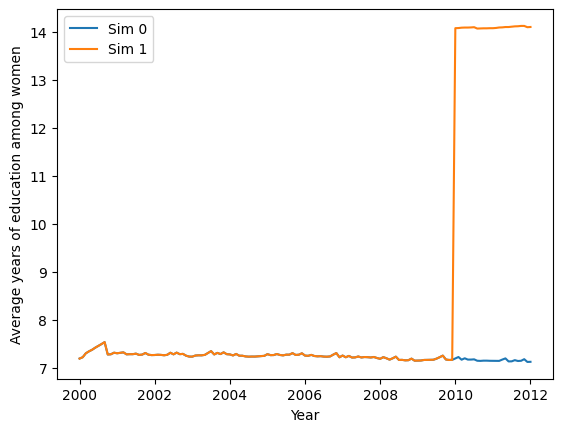

In [8]:
plt.plot(s0.results.timevec, s0.results.edu_attainment, label=s0.label)
plt.plot(s1.results.timevec, s1.results.edu_attainment, label=s1.label)
plt.ylabel('Average years of education among women')
plt.xlabel('Year')
plt.legend()